In [90]:
import pandas as pd
import pandas_datareader as web
import numpy as np

In [2]:
(initial_day, rf) = ('2021-11-11', 0)

In [113]:
df = pd.read_excel('Stocks_List.xlsx')
df = df.dropna(axis='index', how='all')
df = df.dropna(axis='columns', how='all')
df.columns=df.iloc[0]
df.drop(index=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
stocks_list = df
tickers = stocks_list.iloc[:,0].values

In [5]:
# fetching prices
stocks_prices = pd.DataFrame()
for ticker in tickers:
    stocks_prices[ticker] = web.DataReader(ticker, 'yahoo', '2021-11-11')['Close']

In [6]:
bench_prices = pd.DataFrame()
bench_prices['SPY'] = web.DataReader('SPY', 'yahoo', '2021-11-11')['Close']

In [127]:
stocks_daily_returns = (stocks_prices.diff()/stocks_prices.shift(1))[1:] # remove the first NaN row
bench_daily_returns = (bench_prices.diff()/bench_prices.shift(1))[1:]

In [83]:
last_prices = stocks_prices.tail(1).iloc[0].values # np array
quants_prior = stocks_list.iloc[:,1].values
weights_prior = last_prices*quants_prior/(last_prices*quants_prior).sum()

In [121]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import pypfopt.plotting as plotting
import matplotlib.pyplot as plt

In [123]:
mu = mean_historical_return(stocks_prices)
S = CovarianceShrinkage(stocks_prices).ledoit_wolf()

# mean-variance opt
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

clean_weights = ef.clean_weights()
print("Estimated weights (max sharpe): \n {0}\n".format(dict(clean_weights)))

{'SPY': 0.0, 'AAPL': 1.0, 'MSFT': 0.0, 'TSLA': 0.0}


In [116]:
weights_current = np.array(list(clean_weights.values()))
quants_current = (weights_current * (last_prices*quants_prior).sum()/last_prices).round()
diff_invest = (last_prices*(quants_current-quants_prior)).sum()

In [108]:
buy_or_sell = quants_current - quants_prior
buy_or_sell = pd.DataFrame({'Buy/Sell_qts': buy_or_sell, 'Amount': last_prices*buy_or_sell, 'Tickers': tickers})
buy_or_sell.set_index(['Tickers'], inplace=True)
print(buy_or_sell)

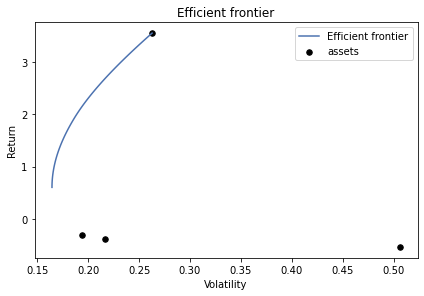

In [151]:
ef = EfficientFrontier(mu, S)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
ax.set_title('Efficient frontier')
plt.show()

In [147]:
portfolioReturn = stocks_daily_returns.mul(weights_prior).sum(axis='columns')
Opt_portfolioReturn = stocks_daily_returns.mul(weights_current).sum(axis='columns')
rets_df = pd.concat([portfolioReturn, Opt_portfolioReturn, bench_daily_returns], axis='columns')
rets_df.columns=['Currenty','Optimized','SPY']